# 1. Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import datetime as dtime
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import tqdm as tqdm

In [2]:
# 금리 데이터
KOR_rateCurve = pd.read_excel("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\\HanaDT_QuantChallenge_금리커브_데이터.xlsx", sheet_name=0)
US_rateCurve = pd.read_excel("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\\HanaDT_QuantChallenge_금리커브_데이터.xlsx", sheet_name=1)
EUR_rateCurve = pd.read_excel("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\\HanaDT_QuantChallenge_금리커브_데이터.xlsx", sheet_name=2)

# 옵션 시장 데이터
EURO_imvol1 = pd.read_csv("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\HanaDT_QuantChallenge_옵션시장_데이터_EUROSTOXX50_2021-06-09.csv")
EURO_imvol2 = pd.read_csv("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\HanaDT_QuantChallenge_옵션시장_데이터_EUROSTOXX50_2021-12-09.csv")
EURO_imvol3 = pd.read_csv("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\HanaDT_QuantChallenge_옵션시장_데이터_EUROSTOXX50_2022-06-09.csv")

KOSPI_imvol1 = pd.read_csv("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\HanaDT_QuantChallenge_옵션시장_데이터_KOSPI200_2021-06-09.csv")
KOSPI_imvol2 = pd.read_csv("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\HanaDT_QuantChallenge_옵션시장_데이터_KOSPI200_2021-12-09.csv")
KOSPI_imvol3 = pd.read_csv("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\HanaDT_QuantChallenge_옵션시장_데이터_KOSPI200_2022-06-09.csv")

SNP_imvol1 = pd.read_csv("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\HanaDT_QuantChallenge_옵션시장_데이터_S&P500_2021-06-09.csv")
SNP_imvol2 = pd.read_csv("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\HanaDT_QuantChallenge_옵션시장_데이터_S&P500_2021-12-09.csv")
SNP_imvol3 = pd.read_csv("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\HanaDT_QuantChallenge_옵션시장_데이터_S&P500_2022-06-09.csv")

#환 데이터
fx_data = pd.read_excel("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\HanaDT_QuantChallenge_FX_종가_데이터.xlsx", index_col = 0)[::-1]
won_dollar = pd.DataFrame(fx_data["KRW/USD"] , index =fx_data.index )
won_eur = pd.DataFrame(fx_data["KRW/EUR"] , index =fx_data.index )

#기초자산 데이터
df_kospi = pd.read_excel("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\\HanaDT_QuantChallenge_기초자산_종가_데이터.xlsx", index_col=0,header=None)[::-1]["2018-01-02":]
df_euro = pd.read_excel("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\\HanaDT_QuantChallenge_기초자산_종가_데이터.xlsx", sheet_name=1,index_col=0,header=None)[::-1]["2018-01-02":]
df_snp = pd.read_excel("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\\HanaDT_QuantChallenge_기초자산_종가_데이터.xlsx",sheet_name=2,index_col=0,header=None)[::-1]["2018-01-02":]

df_snp.index = pd.to_datetime(df_snp.index)
df_kospi.index = pd.to_datetime(df_kospi.index)
df_euro.index = pd.to_datetime(df_euro.index)

df_snp.columns = ["snp"]
df_kospi.columns = ["kos"]
df_euro.columns = ["eur"]

#배당
KOS_div = pd.read_excel("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\\HanaDT_QuantChallenge_이산배당_데이터.xlsx")
EURO_div = pd.read_excel("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\\HanaDT_QuantChallenge_이산배당_데이터.xlsx", sheet_name=1)
SNP_div = pd.read_excel("C:\\Users\\gram\\OneDrive\\바탕 화면\\HanaQuantChallenge-Pricing_Quant\\HanaDT_QuantChallenge_이산배당_데이터.xlsx", sheet_name=2)

# 2. ELS Parent Class 정의

In [3]:
class ELS_3STAR:
    '''
    3Star ELS를 평가 하기 위한 기본 함수들을 정의하였으며 본격적인 프라이싱과 델타헤징 함수
    들은 자식 클래스에서 구현함. 자식클래스는 두개로 Case 2/4, Case 1/3으로 나눔.
    여기서 기본함수라는 것은  local vol, risk free rate term structure 등을 구하는 함수를 의미함
    '''
    def __init__(self, sim_num, T, dt, Face_value,val_date):
        self.sim_num = sim_num                                          # 시뮬레이션 수
        self.T = T                                                      # 만기
        self.dt = dt                                                    # 시뮬레이션 주기 ex) dt가 1/52라면 1주일마다 한번 주가를 시뮬레이션
        self.Face_value = Face_value                                    # 액면가. 본 시뮬레이션에선 10000으로 고정
        self.val_date = val_date                                        # ELS 발행일



    def Local_vol(self, df_imvol):
        '''
        옵션 시장 데이터에서 imvol을 가져와 Local Vol로 바꾸자 한다

        df_imvol = 옵션 시장 데이터 : 데이터프레임
        val_date = 발행일 : 날짜
        S0 = 기초자산 초기 값 : int

        '''

    # 전체 데이터 프레임에서 imvol데이터만 가져와 로컬볼로 바꾸기 위한 프로세스

        # 1. 행=행사가, 열=만기, 값 = imvol인 피벗테이블 만들기. 행사가는 상대적 행사가를 사용함. df_imvol_pivot이 피벗으로 바꾼 테이블임.
        df_imvol = df_imvol.loc[:,["Expiration Date","Relative Strike","Volatility"]].dropna()                          
        df_imvol_pivot = df_imvol.pivot(index = "Relative Strike", columns="Expiration Date", values = "Volatility") 

        # 1-1 만기가(열) 연도로 되어있는 것을 val_date과의 일수 차이로 바꿔줌 -> 차후 델타 해징시 일수차이에 따라 선형보간하기 위함
        day_diff = np.array([])                                                                     # 일수 차이 어레이. 차후 해당 어레이가 열이름이 됨. 
        valuation_date = dtime.datetime.strptime(self.val_date,"%Y-%m-%d")                          # val_date의 단순 타입 변환

        for i in range(len(df_imvol_pivot.columns)):
            '''valuation_date과 열에 있는 값의 차이를 구하여 df_imvol_pivot의 열로 바꿈'''
            reltaive_date  = dtime.datetime.strptime(df_imvol_pivot.columns[i],"%Y-%m-%d")          # 비교하고자 하는 날     
            date_diff = (reltaive_date - valuation_date)                                            # 일수차이 계산
            day_diff = np.append(day_diff,np.array([date_diff.days]))                               # day_diff에 일수차이 append

        df_imvol_pivot.columns = day_diff.astype(int)                                                                                      


        # 2. 로컬볼로 바꾸기 
        strike_list = df_imvol_pivot.index.values.astype(int)                                       # 행사가 리스트
        Vendor_IV = np.array(df_imvol_pivot.T)                                                      # 단순히 주어진 imvol 데이터임. df_imvol_pivot를 Transpose한 것.
        TT = df_imvol_pivot.T.index.values
        K = strike_list
        R = len(TT)
        C = len(K)
        basis = 252                                                                                 # 1년 252일로 가정
        T = TT/basis
        w = np.zeros([R, C])                                                                        # 해당 어레이가 lv로 채워질 것

        # 내제 분산 계산
        for j in range(C):
            w[:,j] = (Vendor_IV[:,j]**2) * T           

        # Forwards prices,  
        y = np.log(K/100)         

        # Allocation
        # d가 앞에 붙은 것은 각 변수를 한번 미분했다는 것. 해당 어레이들은 차후 계산에 사용
        dwdT = np.zeros((R,C))
        dwdy = np.zeros((R,C))
        dw2dy2 = np.zeros((R,C))                                                                    # 각 변수 두번 미분
        IV = np.zeros((R,C))
        LV = np.zeros((R,C))

        # 변화분 설정
        dt = 10e-6
        dy = 1e-10
        T0 = T - dt
        T2 = T + dt
        y0 = y - dy
        y2 = y + dy

        # 시간에 대한 1차 미분 값 (backward로 함)
        # 시간이 아주 조금 변했을 때의 내제 분산값을 계산하기 위해 선형보간함수 사용
        for j in range(C):
            f = interp1d(T,w[:,j],kind='linear',fill_value='extrapolate')   
            w0 = f(T0)
            dwdT[:,j] = (w[:,j] - w0)/(T - T0)                   

        # Moneyness에 대한 1차 미분값 (Central)
        for i in range(R): 
            # Forwards price가 아주 조금 변했을때의 내제 분산값을 계산하기 위해 선형보간함수 사용
            f = interp1d(y,w[i,:],kind='linear',fill_value='extrapolate')   
            w0 = f(y0)
            w2 = f(y2)
            dwdy[i,:] = (w2 - w0) / (y2 - y0)          

        # Moneyness에 대한 2차 미분값 (Central)
        for i in range(R): 
            f = interp1d(y,dwdy[i,:],kind='linear',fill_value='extrapolate')
            w0 = f(y0)
            w2 = f(y2)
            dw2dy2[i,:] = (w2 - w0) / (y2 - y0)          

        # Jim Gatheral's book (the volatility surface) 의 공식을 사용하여 imvol을 로컬볼로 바꿈
        for i in range(R): 
            for j in range(C):
                num = dwdT[i,j]
                den = 1 - (y[j]/w[i,j])*dwdy[i,j] + 0.25*(-0.25 - 1/w[i,j] + (y[j]**2)/(w[i,j]**2))*(dwdy[i,j]**2) + 0.5*dw2dy2[i,j]
                LV[i,j] = np.sqrt(num/den)

        
        df_LV = pd.DataFrame(LV, index = (df_imvol_pivot.T.index) , columns=df_imvol_pivot.T.columns).T

        return df_LV

    
    def interpolating_LocalVol(self,local_vol_table):
        '''
        df_imvol이 Local_vol함수를 통과하게 되면 Vendor_IV와 같은 크기의 local vol 표를 얻게 된다.
        주가 시뮬레이션시 해당 표를 사용하여 랜덤하게 주어지는 주가와 흐르는 시간에 맞는 
        로컬볼을 얻기 위해 local vol 선형보간 함수를 만들고자 한다
        ''' 
        strike_li = local_vol_table.index.values.astype(int)        # 옵션 시장 데이터에서 준 상대적 행사가 (50~150, 13개)
        days = local_vol_table.columns.values.astype(int)           # Local_vol 함수에서 설정한 만기까지 남은 일수 
        x = days                                                    
        y = strike_li                                               
        z = local_vol_table.values                                  
        f = interpolate.interp2d(x,y,z,kind="linear")               # f안에 x(시간), y(주가)를 넣으면 선형보간된 로컬 볼 값이 계산된다
        return f


    def Dividend_yield_interploation(self, df_imvol):
        '''
        interpolating_LocalVol과 같은 메커니즘을 가지고 옵션 시장 데이터에서 주어진 Dividend Yield를 
        선형 보간하고자 한다. 해당 함수는 차후 주가 시뮬레이션시 배당(q값)으로 사용한다. 단, Dividend Yield은 시간에만 영향을 받고 
        행사가에는 영향을 받지 않기에 시뮬레이션시 strike 요소는 고정시켜 계산 한다. 
        '''

        # Local_vol,interpolating_LocalVol과 같은 프로세스를 거친다. 값만 배당으로 바뀌었을 뿐이다.
        df_imvol = df_imvol.loc[:,["Expiration Date","Relative Strike","Dividend Yield"]].dropna()
        df_imvol_pivot = df_imvol.pivot(index = "Relative Strike", columns="Expiration Date", values = "Dividend Yield")

        day_diff = np.array([])
        valuation_date = dtime.datetime.strptime(self.val_date,"%Y-%m-%d")
        for i in range(len(df_imvol_pivot.columns)):
            reltaive_date  = dtime.datetime.strptime(df_imvol_pivot.columns[i],"%Y-%m-%d")
            date_diff = (reltaive_date - valuation_date)
            day_diff = np.append(day_diff,np.array([date_diff.days]))
        df_imvol_pivot.columns = day_diff.astype(int)
        strike_list = df_imvol_pivot.index.values.astype(int)

        ridx = df_imvol_pivot.index.values.astype(int)
        cindex= df_imvol_pivot.columns.values.astype(int)
        x = cindex
        y = ridx
        z = df_imvol_pivot.values
        f = interpolate.interp2d(x,y,z,kind="linear")

        return f

    def corr_term(self):
        '''
        세 자산간의 상관계수를 계산하고자 한다. val_date 까지의 가격만 반영하기 위해 해당 행까지만 추출하였다
        (아래 자산 데이터 프레임들의 행은 날짜, 열은 가격으로 1차원이다). 상관계수는 rho라고 하였으며 어떤 자산끼리의
        rho인지 알기위해 뒤에 두 국가이름을 붙였다.  
        '''
        corr_table = pd.concat([df_kospi[:self.val_date],df_snp[:self.val_date],df_euro[:self.val_date]], axis=1).corr()
        rho_uskor = corr_table.loc["kos","snp"]
        rho_eurkor = corr_table.loc["eur","snp"]
        rho_useur = corr_table.loc["kos","eur"]

        return rho_uskor,rho_eurkor,rho_useur


    def fx_term(self):
        '''
        snp와 euro 가격 시뮬레이션시 고려해야하는 (환변동성 * 자산과 환의 상관계수 * 자산 자체의 변동성) term을 계산하고자함 
        '''
        won_dollar_std1 = won_dollar[:self.val_date].pct_change().std()*np.sqrt(252)                                                    # 환율 퍼센트 변화의 표준편차 (1년 252일 기준 연율화 하였음)
        won_eur_std1 = won_eur[:self.val_date].pct_change().std()*np.sqrt(252)
        df_eur_std1 = (pd.DataFrame(df_euro.loc[:self.val_date,"eur"].values).pct_change().std()*np.sqrt(252))[0]                       # 자산의 표준편차 (1년 252일 기준 연율화 하였음)                 
        df_snp_std1 = (pd.DataFrame(df_snp.loc[:self.val_date,"snp"].values).pct_change().std()*np.sqrt(252))[0]

        corr_wonDollar_n_SNP1 = pd.concat([won_dollar[:self.val_date],df_snp[:self.val_date]],axis=1).interpolate().corr().iloc[1,0]    # 환과 관련된 자산간의 상관계수
        corr_wonEuro_n_EURO1 = pd.concat([won_eur[:self.val_date],df_euro[:self.val_date]],axis=1).interpolate().corr().iloc[1,0]

        drift_minus2 = (won_dollar_std1 * corr_wonDollar_n_SNP1*df_snp_std1)[0]                                                         # 계산된 값
        drift_minus3 = (won_eur_std1 * corr_wonEuro_n_EURO1*df_eur_std1)[0]

        return drift_minus2,drift_minus3


    def functionsForSim(self):
        '''
        val_date에 맞는 데이터를 선정하여 각 ELS에 맞는 선형보간 함수들을 만들고자 한다.
        '''   

        #val_date에 따라 달리 사용되는 옵션 시장 데이터와 금리커브 데이터를 정해줌
        if self.val_date == "2021-06-09":
            rate_num = 1                                       
            eu_imvol = EURO_imvol1
            kor_imvol = KOSPI_imvol1
            us_imvol = SNP_imvol1
            
        elif self.val_date == "2021-12-09":
            rate_num = 2
            eu_imvol = EURO_imvol2
            kor_imvol = KOSPI_imvol2
            us_imvol = SNP_imvol2
            
        elif self.val_date == "2022-06-09":
            rate_num = 3
            eu_imvol = EURO_imvol3
            kor_imvol = KOSPI_imvol3
            us_imvol = SNP_imvol3

        else:
            print("wrong valuation date")


        # 금리 커브 데이터는 ELS 만기에 맞춰 3년까지만 사용
        kor3y = KOR_rateCurve.iloc[1:7,rate_num]
        us3y = US_rateCurve.iloc[1:7,rate_num]
        eur3y = EUR_rateCurve.iloc[1:7,rate_num]
        daily_index = [3*21, 6*21,9*21,12*21,24*21,36*21]                   # 선형 보간을 위해 index를 통일해줌 (일수화, 한달을 21로 가정)


        # 자산간 상관계수 계산 (상수로 사용)
        rho_uskor,rho_eurkor,rho_useur = ELS_3STAR.corr_term(self)


        # drift term에서 빼주어야 하는 환관련 term 계산 (상수로 사용)
        fxTerm_us, fxTerm_eu = ELS_3STAR.fx_term(self)


        # 이자율 선형보간 함수 (함수 파리미터: 일 수)
        kor_intRates_f = interpolate.interp1d(daily_index,kor3y.values,kind = "quadratic",fill_value="extrapolate")
        us_intRates_f = interpolate.interp1d(daily_index,us3y.values,kind = "quadratic",fill_value="extrapolate")
        eur_intRates_f = interpolate.interp1d(daily_index,eur3y.values,kind = "quadratic",fill_value="extrapolate")


        #로컬 볼 표 만들기 (한번 만들면 로컬볼 표 자체는 주가나 시간에 따라 바뀌지 않음)
        eur_lv = ELS_3STAR.Local_vol(self,eu_imvol)
        kos_lv = ELS_3STAR.Local_vol(self,kor_imvol)
        snp_lv = ELS_3STAR.Local_vol(self,us_imvol)


        #로컬볼 표를 사용하여 로컬볼 선형보간 함수를 만듬 
        eur_lv_f = ELS_3STAR.interpolating_LocalVol(self,eur_lv)            # eur_lv_f 파라미터로 일 수와 주가가 들어감.
        kos_lv_f = ELS_3STAR.interpolating_LocalVol(self,kos_lv)
        snp_lv_f = ELS_3STAR.interpolating_LocalVol(self,snp_lv)


        #배당 선형보간 함수
        eur_div_f = ELS_3STAR.Dividend_yield_interploation(self,eu_imvol)
        kos_div_f = ELS_3STAR.Dividend_yield_interploation(self,kor_imvol)
        snp_div_f = ELS_3STAR.Dividend_yield_interploation(self,us_imvol)


        return rho_uskor,rho_eurkor,rho_useur,fxTerm_us, fxTerm_eu, kor_intRates_f,us_intRates_f,eur_intRates_f,eur_lv_f,kos_lv_f,snp_lv_f,eur_div_f,kos_div_f,snp_div_f

    # 시뮬레이션, 델타 헤징, 프라이싱은 자식클래스에서 정의
    def simulate_stockPath(self):
        pass

    def deltaHedge(self):
        pass

    def price_ELS(self):
        pass

## 2.1) Case 2 and 4

In [4]:
class Case2n4(ELS_3STAR):
    
    def __init__(self, sim_num, T, dt, Face_value, val_date):
        super().__init__(sim_num, T, dt, Face_value,val_date)  # 부모 클래스와 같음

        '''해당 함수를 사용하여 functionsForSim 반환값들을 해당 클래스에서 사용할 수 있게 하고자 함'''
        self.rho_uskor,self.rho_eurkor,self.rho_useur,self.fxTerm_us, self.fxTerm_eu, \
        self.kor_intRates_f,self.us_intRates_f, self.eur_intRates_f,self.eur_lv_f,\
        self.kos_lv_f,self.snp_lv_f,self.eur_div_f,self.kos_div_f,self.snp_div_f = Case2n4.functionsForSim(self)


    def simulate_stockPath(self,iter_num, S0_1, S0_2, S0_3):
        '''
        주가 시뮬레이션 함수.
        S0s : 초기 주가
        iter_num : 델타 헤징에서 사용. 선형 보간 함수들 일 수 파라미터에 지나간 시간(1=하루) 만큼 더해주기 위함임. 
        '''

        # 시뮬레이션시 실제 자산 수익률을 시뮬레이션에 사용 (로그 리턴)
        idx_num = np.where(df_kospi.index == self.val_date)[0][0]
        MuK = (np.log(df_kospi.iloc[:idx_num+iter_num]).diff().mean()*252).repeat(self.sim_num)
        MuS = (np.log(df_snp.iloc[:idx_num]+iter_num).diff().mean()*252).repeat(self.sim_num)
        MuE = (np.log(df_euro.iloc[:idx_num]+iter_num).diff().mean()*252).repeat(self.sim_num)


        # time_steps는 시뮬레이션 표의 시간인 열을 나타냄 (행은 시뮬레이션 수)
        # 3년을 시뮬레이션 하기에 dt가 1/52라면 156이 됨.
        time_steps = int(np.ceil( (self.T - iter_num/252) /self.dt))

        
        one_step = 252*self.dt                                # one_step ex)52주라면 약 5일이 one step

        #난수 생성
        z1_table = np.random.randn(self.sim_num,time_steps+1) #초기값을 추가적으로 넣어줘야하기에 time_steps+1개의 열을 최종적으로 만든다
        z2_table = np.random.randn(self.sim_num,time_steps+1)
        z3_table = np.random.randn(self.sim_num,time_steps+1)

        # 초기값 설정 / 
        z1_table[:,0], z2_table[:,0], z3_table[:,0] = S0_1, S0_2, S0_3

        # 콜레스키 분해를 사용하여 snp와 eur diffusion term 계산
        diff_term12 = ( self.rho_uskor * z1_table + np.sqrt( 1-self.rho_uskor**2 )*z2_table )
        diff_term13 = ( self.rho_eurkor * z1_table ) + \
                      ( ( (self.rho_useur-self.rho_eurkor*self.rho_uskor) / np.sqrt(1-self.rho_uskor**2) ) *z2_table ) + \
                      ( np.sqrt( 1 - self.rho_eurkor**2 - ( ( self.rho_useur-self.rho_uskor*self.rho_eurkor )**2 /( 1-self.rho_uskor**2 ) ) ) * z3_table ) 

        for i in range(1,time_steps+1): 
            # 선형보간된 로컬볼값 계산
            sig1 = self.kos_lv_f((i-1)*one_step+ iter_num,z1_table[:,i-1]).flatten()        # (i-1)*one_step = 지나간 일 수. 해당 함수는 i를 하루로만 인식하기에 one_step을 곱해주어야함
            sig2 = self.snp_lv_f((i-1)*one_step+ iter_num,z2_table[:,i-1]).flatten()        # iter_num은 델타 해징시 지난간 시간을 보정해 주기 위해 더해 줌
            sig3 = self.eur_lv_f((i-1)*one_step+ iter_num,z3_table[:,i-1]).flatten()


            # 선형보간된 배당 계산
            q1 = self.kos_div_f((i-1)*one_step + iter_num,0)                                # 로컬볼값 계산과 같으며 행사가는 상관이 없어 0으로 고정
            q2 = self.snp_div_f((i-1)*one_step + iter_num,0)
            q3 = self.eur_div_f((i-1)*one_step + iter_num,0) 


            # 시뮬레이션 진행. Gemetric Brownian Motion 가정
            z1_table[:,i] = z1_table[:,i-1] * np.exp( (MuK-q1-0.5*sig1**2)*self.dt + sig1*np.sqrt(self.dt)* z1_table[:,i] )
            z2_table[:,i] = z2_table[:,i-1] * np.exp( (MuS-q2-self.fxTerm_us-0.5*sig2**2)*self.dt + sig2*np.sqrt(self.dt)* diff_term12[:,i] )
            z3_table[:,i] = z3_table[:,i-1] * np.exp( (MuE-q3-self.fxTerm_eu-0.5*sig3**2)*self.dt + sig3*np.sqrt(self.dt)* diff_term13[:,i] )


        return z1_table,z2_table,z3_table


    def half_year_list(self,iter_num):
        '''
        dt에 따라 계산되는 조기상환 날의 인덱스 어레이와 (half_year_idx)
        각 인덱스에 맞는 half_year_points(0.5,1,1.5,2,2.5,3)를 설정함 
        '''
        half_year_idx = np.zeros(6)                                         # 3년까지 조기상환 횟수가 6번
        for i in range(6):
            half_year_idx[i] = int((0.5/self.dt)*(i+1))

        half_year_points = np.flip(half_year_idx/(1/self.dt))
        half_year_idx = np.flip(half_year_idx.astype(int))
        
        prepayed_num = int(np.ceil(6 - (iter_num/252)*2))                   # iter_num에 따라 남은 조기상환 횟수를 계산
        
        half_year_idx = half_year_idx[:prepayed_num][::-1]                  # 남은 조기상환 횟수에 따라 half_year_idx,half_year_points 어레이 길이 설정
        half_year_points = half_year_points[:prepayed_num][::-1]            # ex) iter_num이 252라면 prepayed_num = 4가 되며 half_year_points 어레이는 [1.5,2,2.5,3]가 된다.
                                                                            # dt가 1/52라면 half_year_idx 어레이는 [78, 104, 130, 156] 가 된다 (반년 index인 26에 2*half_year_points를 곱한 것)
        return half_year_points,half_year_idx



    def price_ELS(self,step_down_li,prePay_rate_li, iter_num, S0_1,S0_2,S0_3): 
        ''' 

        시뮬레이션된 주가 path들을 가지고 조건에 맞게 ELS pricing을 하고자 한다.

        step_down_li : 자동 조기 상환 조건 어레이 (i.e. 95%, 90% ...)
        prePay_rate_li : 각 조기상환 시점에서 받게 되는 금리
        S0_1,S0_2,S0_3 : 시뮬레이션 초기 값

        '''
        
        # 자산별로 시뮬레이션된 어레이들과 반년 idx 계산
        simPath1,simPath2,simPath3 = Case2n4.simulate_stockPath(self,iter_num,S0_1, S0_2,S0_3)          
        half_year_points,half_year_idx = Case2n4.half_year_list(self,iter_num)                          


        # 남은 조기상환 수 만큼만 추출 
        step_down_li = step_down_li[6-len(half_year_points):]
        prePay_rate_li = prePay_rate_li[6-len(half_year_points):]

        # 시간이 가며 변화되는 반년 인덱스를 보정해줌
        last_index = simPath1.shape[1]-1                                    
        for i in range(len(half_year_points)):
            '''
            last_index는 simulate_stockPath내부 계산에 따라 변화될 것이며(iter_num에 의해)
            흐른 시간을 기점으로 조기상환 시점 인덱스를 다시 계산
            -half_year_points의 길이가 4라면 가장 half_year_idx 가장 뒤 두 원소를 제거하는 어레이 pop 함수와 비슷하게 작동 함.
            '''
            half_year_idx[i] = last_index - int(0.5/self.dt)*i
        half_year_idx = half_year_idx[::-1]


        df_pmt = pd.DataFrame()         # 조건에 따라 상환받는 금액을 담은 데이터프레임


        for i in range(len(half_year_points)):              # half_year_points의 길이는 남은 조기상환 기회
            '''step_down_li에 있는 조건을 알맞은 시기에 각 자산들이 만족하는지 확인'''
            df_pmt[i] = np.where( (simPath1[:,half_year_idx[i]] >= 100*step_down_li[i]) & \
                                  (simPath2[:,half_year_idx[i]] >= 100*step_down_li[i]) & \
                                  (simPath3[:,half_year_idx[i]] >= 100*step_down_li[i]), \
                                   self.Face_value * (1+prePay_rate_li[i]) * np.exp(-self.kor_intRates_f(half_year_points[i]*252)*(half_year_points[i]-iter_num/252)) , 0) 
                                   # kor_intRates_f(일수)인데 half_year_points는 연율화된 숫자라 252를 곱해줌
                                  

        temp= np.where(simPath1[:,-1]>simPath2[:,-1], 
                       np.where(simPath2[:,-1] > simPath3[:,-1],simPath3[:,-1],simPath2[:,-1]), #simPath2[:,-1]가 더 작으므로 path3와 비교하여 더 작은수를 고름
                       np.where(simPath1[:,-1] > simPath3[:,-1],simPath3[:,-1], simPath1[:,-1])) #simPath2[:,-1]가 더 크니 path1과 3을 비교하여 더 작은수를 고름

        # 만기상환 2차 조건
        df_pmt[len(step_down_li)] = np.where((simPath1[:,-1] < 100*step_down_li[-1]) | #하나라도 70%미만인가
                                             (simPath2[:,-1] < 100*step_down_li[-1]) | 
                                             (simPath3[:,-1] < 100*step_down_li[-1]), 
                                             self.Face_value * temp/100 * np.exp(-self.kor_intRates_f(half_year_points[-1]*252)*(self.T - iter_num/252)) ,0)


        # df_pmt는 현재 각 조기상환 시점별로 조건을 만족하는지만 판단하여 payoff를 계산한 상태임.
        # 즉, 사전에 조기상환이 되었는지는 판단하지 않음.
        df_pmt = df_pmt.replace(0,np.NaN)
        df_min = pd.DataFrame.min(df_pmt.loc[:,:len(step_down_li)-1],axis=1)    # 최소값만 가져와 가장 먼저 상환된 시점에서의 payoff를 가져옴
        df_temp = pd.concat([df_min,df_pmt.loc[:,len(step_down_li)]],axis=1)    # 만기상환결정금액 2차 조건과 비교하여 max payoff를 가져옴 -> max가 먼저 상환된 금액이기 때문
        agg_pmt = pd.DataFrame.max(df_temp,axis=1)
            
        return agg_pmt.mean()


    def deltaHedge(self,step_down_li,prePay_rate_li,prepay_date_li, sim_num, S0_1, S0_2, S0_3):
        ''' 
        실제 자산 가격 추이 데이터를 가지고 델타헤지 backtesting을 진행함
        여기서 S0_1, S0_2, S0_3는 계속해서 날짜별 실제 주가로 변화함
        '''

        # 1000번 이상 시뮬레이션시 시간이 너무 오래걸려 새로 시뮬레이션 수를 받음
        self.sim_num = sim_num

        kk=(df_kospi.loc[self.val_date:] / df_kospi.loc[self.val_date,"kos"] *100)   # 첫날 가격으로 나머지날의 가격을 나누어주어 표준화 시킴(100기준)
        ss=(df_snp.loc[self.val_date:] / df_snp.loc[self.val_date,"snp"]* 100)
        ee=(df_euro.loc[self.val_date:] / df_euro.loc[self.val_date,"eur"]* 100)
        underlying_agg=pd.concat([kk,ss,ee],axis=1).ffill()

        # 조기상환 여부를 판단하여 어느 지점까지 시뮬레이션해야하는지 인덱스를 찾아냄. 조기상환이 되지 않으면 끝까지 시뮬레이션함

        limit_idx = len(underlying_agg)
        for i in range(len(prepay_date_li)):
            a = (np.sum(underlying_agg.loc[(prepay_date_li[i]),:] > step_down_li[i]*100)==3)   # 조기상환 가능 날짜에 모두 true면 조기상환되며 합해서 3이 되어야함

            if (a == True): 
                limit_idx = np.where(underlying_agg.index == prepay_date_li[i])[0][0]
                break


        df_delta = pd.DataFrame()
        agg_arr = np.zeros([2, 3, limit_idx]) # 기존 주가에서 1% up과 down 경우수 2개, 자산 3개, 날짜수 만큼의 열

        #각 자산을 1%씩 변화하여 자산별 델타를 구함. (Value(s + ds) + Value(s-ds))/2 공식 사용
        for i in tqdm.tqdm(range(limit_idx)): 
            agg_arr[0,0,i] = Case2n4.price_ELS(self,step_down_li,prePay_rate_li, i, underlying_agg.iloc[i,0]*1.01, underlying_agg.iloc[i,1], underlying_agg.iloc[i,2])
            agg_arr[0,1,i] = Case2n4.price_ELS(self,step_down_li,prePay_rate_li, i, underlying_agg.iloc[i,0], underlying_agg.iloc[i,1]*1.01, underlying_agg.iloc[i,2])
            agg_arr[0,2,i] = Case2n4.price_ELS(self,step_down_li,prePay_rate_li, i, underlying_agg.iloc[i,0], underlying_agg.iloc[i,1], underlying_agg.iloc[i,2]*1.01)

            agg_arr[1,0,i] = Case2n4.price_ELS(self,step_down_li,prePay_rate_li, i, underlying_agg.iloc[i,0]*0.99, underlying_agg.iloc[i,1], underlying_agg.iloc[i,2])
            agg_arr[1,1,i] = Case2n4.price_ELS(self,step_down_li,prePay_rate_li, i, underlying_agg.iloc[i,0], underlying_agg.iloc[i,1]*0.99, underlying_agg.iloc[i,2])
            agg_arr[1,2,i] = Case2n4.price_ELS(self,step_down_li,prePay_rate_li, i, underlying_agg.iloc[i,0], underlying_agg.iloc[i,1], underlying_agg.iloc[i,2]*0.99)

        df_delta["KOS"] = (agg_arr[0,0,:] - agg_arr[1,0,:])/2
        df_delta["SNP"] = (agg_arr[0,1,:] - agg_arr[1,1,:])/2
        df_delta["EUR"] = (agg_arr[0,2,:] - agg_arr[1,2,:])/2

        df_del_diff = df_delta.diff()
        df_del_diff.iloc[0,:] = df_delta.iloc[0,:]
        df_del_diff["Total Delta"] = df_del_diff.sum(axis=1)


        return df_del_diff

## 2.2) Case 1 and 3

In [54]:
class Case1n3(Case2n4):
    def __init__(self, sim_num, T, dt,Face_value,val_date):
        # Case2n4와 같은 변수들 
        super().__init__(sim_num, T, dt,Face_value,val_date)
        self.sim_num = sim_num
        self.T = T
        self.dt = dt
        self.Face_value = Face_value
        self.val_date = val_date
        

    def price_ELS(self, barrier, step_down_li_2nd,step_down_li,prePay_rate_li,iter_num, S0_1, S0_2, S0_3):
        '''
        기본적인 변수들, 알고리즘은 Case2n4와 동일하여 중복되는 설명은 생략. 추가되는 부분만 주석처리.
        
        barrier : 해당 과제에선 50%로 고정
        step_down_li_2nd: Case1n3에 추가된 x-2차 조건 어레이 
        '''
        
        simPath1,simPath2,simPath3 = Case1n3.simulate_stockPath(self,iter_num, S0_1, S0_2, S0_3)
        half_year_points,half_year_idx = Case1n3.half_year_list(self,iter_num)

        step_down_li = step_down_li[6-len(half_year_points):]
        prePay_rate_li = prePay_rate_li[6-len(half_year_points):]
        step_down_li_2nd = step_down_li_2nd[6-len(half_year_points):]        # Case1n3에 추가된 x-2차 조건 어레이 역시 남은 조기상환 수 만큼만 가져옴


        last_index = simPath1.shape[1]-1
        for i in range(len(half_year_points)):
            half_year_idx[i] = last_index - int(0.5/self.dt)*i

        half_year_idx = half_year_idx[::-1]


        df_pmt = pd.DataFrame()
        df_pmt2 = pd.DataFrame()    # 만기 상환금액 조건 3가지중 첫 경우(모두 70% 이상)를 제외한 나머지 두 경우를 담은 데이터프레임 
        for i in range(len(half_year_points)):
            # Case2n4와 같은 기본 조건.   
            df_pmt[i] = np.where( ( ((simPath1[:,half_year_idx[i]] >= 100*step_down_li[i]) &                                    
                                     (simPath2[:,half_year_idx[i]] >= 100*step_down_li[i]) &  
                                     (simPath3[:,half_year_idx[i]] >= 100*step_down_li[i])) 
                                     
                                     |  

                                        (   # 추가된 x-2차 조건들. 위의 기존 조건은 달성하지 못한 경우를 추출
                                            ((simPath1[:,half_year_idx[i]] < 100*step_down_li[i]) |        
                                             (simPath2[:,half_year_idx[i]] < 100*step_down_li[i]) |        
                                             (simPath3[:,half_year_idx[i]] < 100*step_down_li[i]) ) & 
                                            # 기존 조건은 달성하지 못한 상태에서 세 자산 중 하나라도 dash_2nd_conditions 미만으로 내려간적이 없는 경우
                                            ((np.sum(simPath1[:,:half_year_idx[i]] < 100*step_down_li_2nd[i]) == 0) | 
                                             (np.sum(simPath2[:,:half_year_idx[i]] < 100*step_down_li_2nd[i]) == 0) |  
                                             (np.sum(simPath3[:,:half_year_idx[i]] < 100*step_down_li_2nd[i]) == 0) )      
                                        )
                                  ),

                                    self.Face_value * (1+prePay_rate_li[i]) * np.exp(-self.kor_intRates_f(half_year_points[i]*252)*(half_year_points[i]-iter_num/252)) , 0) 


        # 마지막 시점 주가가 하나라도 70% 미만이며 주가 Path가 베리어를 3년동안 터치하지 않은 경우
        df_pmt2[0] = np.where(  (   (simPath1[:,-1] < 100*step_down_li[-1]) | 
                                    (simPath2[:,-1] < 100*step_down_li[-1]) | 
                                    (simPath3[:,-1] < 100*step_down_li[-1])) 
                                            
                                    &

                                (   (np.sum(simPath1 < 100*barrier, axis=1)==0) & 
                                    (np.sum(simPath2 < 100*barrier, axis=1)==0) &
                                    (np.sum(simPath3 < 100*barrier, axis=1)==0)), 

                                    self.Face_value * (1+prePay_rate_li[-1]) * np.exp(-self.kor_intRates_f(half_year_points[-1]*252)*(half_year_points[-1]-iter_num/252)) ,0)


        # 마지막 시점 주가가 하나라도 70% 미만이며 주가 Path가 3년 동안 베리어를 한번이라도 터치 한 경우
        temp= np.where(simPath1[:,-1]>simPath2[:,-1], 
                       np.where(simPath2[:,-1] > simPath3[:,-1],simPath3[:,-1],simPath2[:,-1]), 
                       np.where(simPath1[:,-1] > simPath3[:,-1],simPath3[:,-1], simPath1[:,-1])) 

        df_pmt2[1] = np.where(  (   (simPath1[:,-1] < 100*step_down_li[-1]) | 
                                    (simPath2[:,-1] < 100*step_down_li[-1]) | 
                                    (simPath3[:,-1] < 100*step_down_li[-1])) 
                                                 
                                    &

                                (   (np.sum(simPath1 < 100*barrier, axis=1) > 0) | 
                                    (np.sum(simPath2 < 100*barrier, axis=1) > 0) |
                                    (np.sum(simPath3 < 100*barrier, axis=1) > 0)), 

                                    self.Face_value * temp/100 * np.exp(-self.kor_intRates_f(half_year_points[i]*252)*(self.T - iter_num/252)) ,0)



        df_pmt = df_pmt.replace(0,np.NaN)
        df_pmt2 = df_pmt2.replace(0,np.NaN)
        df_pmt = pd.DataFrame.min(df_pmt, axis=1)       # 최소 값을 추출하여 가장 먼저 상환 된 금액결정
        df_pmt2 = pd.DataFrame.max(df_pmt2, axis=1)     # 둘중 max가 먼저 상환된 금액
        pmt_12 = pd.concat([df_pmt,df_pmt2],axis=1)
        agg = pd.DataFrame.max(pmt_12,axis=1)

        return agg.mean()

    def limit_index(underlying_agg,prepay_date_li,step_down_li,step_down_li_2nd):
        limit_idx = len(underlying_agg)
        for i in range(len(prepay_date_li)):
            a = (np.sum(underlying_agg.loc[(prepay_date_li[i]),:] < step_down_li[i]*100)==0)    # 기준보다 적은 경우가 한건도 없는 경우 조기상환
            if (a == False) & (i < len(prepay_date_li)):                                        # 1차기준은 만족하지 못했지만 x-2차기준을 만족한 경우 선별
                b = (np.sum(underlying_agg.loc[:(prepay_date_li[i]),:] < step_down_li_2nd[i]*100).sum() == 0)

            if (a == True) | (b ==True):
                limit_idx = np.where(underlying_agg.index == prepay_date_li[i])[0][0]
                break


    def deltaHedge(self,step_down_li, prePay_rate_li, step_down_li_2nd, prepay_date_li, barrier, sim_num):

        self.sim_num = sim_num

        kk=(df_kospi.loc[self.val_date:] / df_kospi.loc[self.val_date,"kos"] *100)
        ss=(df_snp.loc[self.val_date:] / df_snp.loc[self.val_date,"snp"]* 100)
        ee=(df_euro.loc[self.val_date:] / df_euro.loc[self.val_date,"eur"]* 100)
        underlying_agg=pd.concat([kk,ss,ee],axis=1).ffill()

        limit_idx = len(underlying_agg)
        for i in range(len(prepay_date_li)):
            a = (np.sum(underlying_agg.loc[(prepay_date_li[i]),:] < step_down_li[i]*100)==0)    # 기준보다 적은 경우가 한건도 없는 경우 조기상환
            if (a == False) & (i < len(prepay_date_li)):                                        # 1차기준은 만족하지 못했지만 x-2차기준을 만족한 경우 선별
                b = (np.sum(underlying_agg.loc[:(prepay_date_li[i]),:] < step_down_li_2nd[i]*100).sum() == 0)

            if (a == True) | (b ==True):
                limit_idx = np.where(underlying_agg.index == prepay_date_li[i])[0][0]
                break
                    
        print("asd5")
        df_delta = pd.DataFrame()
        agg_arr = np.zeros([2, 3, limit_idx]) 

        for i in tqdm.tqdm(range(limit_idx)): 
            agg_arr[0,0,i] = Case1n3.price_ELS(self, barrier, step_down_li_2nd,step_down_li,prePay_rate_li, i, underlying_agg.iloc[i,0]*1.01, underlying_agg.iloc[i,1], underlying_agg.iloc[i,2])
            agg_arr[0,1,i] = Case1n3.price_ELS(self, barrier, step_down_li_2nd,step_down_li,prePay_rate_li, i, underlying_agg.iloc[i,0], underlying_agg.iloc[i,1]*1.01, underlying_agg.iloc[i,2])
            agg_arr[0,2,i] = Case1n3.price_ELS(self, barrier, step_down_li_2nd,step_down_li,prePay_rate_li, i, underlying_agg.iloc[i,0], underlying_agg.iloc[i,1], underlying_agg.iloc[i,2]*1.01)

            agg_arr[1,0,i] = Case1n3.price_ELS(self, barrier, step_down_li_2nd,step_down_li,prePay_rate_li, i, underlying_agg.iloc[i,0]*0.99, underlying_agg.iloc[i,1], underlying_agg.iloc[i,2])
            agg_arr[1,1,i] = Case1n3.price_ELS(self, barrier, step_down_li_2nd,step_down_li,prePay_rate_li, i, underlying_agg.iloc[i,0], underlying_agg.iloc[i,1]*0.99, underlying_agg.iloc[i,2])
            agg_arr[1,2,i] = Case1n3.price_ELS(self, barrier, step_down_li_2nd,step_down_li,prePay_rate_li, i, underlying_agg.iloc[i,0], underlying_agg.iloc[i,1], underlying_agg.iloc[i,2]*0.99)

        df_delta["KOS"] = (agg_arr[0,0,:] - agg_arr[1,0,:])/2
        df_delta["SNP"] = (agg_arr[0,1,:] - agg_arr[1,1,:])/2
        df_delta["EUR"] = (agg_arr[0,2,:] - agg_arr[1,2,:])/2

        df_del_diff = df_delta.diff()
        df_del_diff.iloc[0,:] = df_delta.iloc[0,:]
        df_del_diff["Total Delta"] = df_del_diff.sum(axis=1)


        return df_del_diff


# 3 Pricing and Delta Hedging

In [46]:
# 공통 변수 설정
sim_num = 10000; T=3; dt=1/52; Face_value=10000; S1 =100; S2=100; S3=100; init_iter_num = 0; Delta_Hedge_sim = 1000

In [11]:
#case 2
val_date2 = "2021-06-09"
prePay_rate_li2 = [0.015,0.03,0.045,0.06,0.075,0.09]
step_down_li2 = [0.95,0.9,0.85,0.8,0.75,0.7]
prepay_date_li2 = ["2021-12-09", "2022-06-09", "2022-12-09"]

inst2 = Case2n4(sim_num,T,dt,Face_value, val_date2)
case2_price = inst2.price_ELS(step_down_li2,prePay_rate_li2,init_iter_num,S1,S2,S3)
case2_price

9701.798934032855

100%|██████████| 413/413 [09:01<00:00,  1.31s/it]


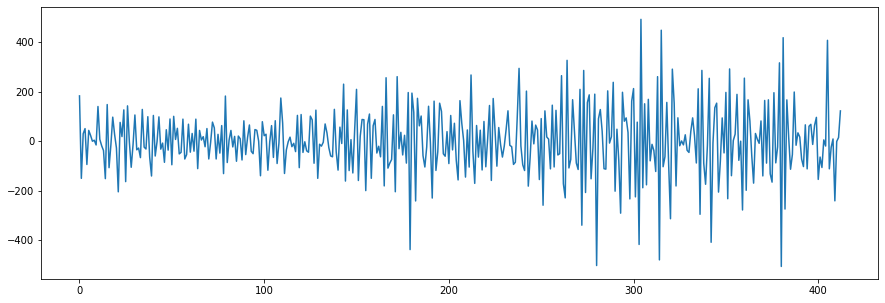

In [8]:
df_del_diff2 = inst2.deltaHedge(step_down_li2,prePay_rate_li2,prepay_date_li2, Delta_Hedge_sim,S1,S2,S3)
plt.figure(figsize=(15,5))
plt.plot(-df_del_diff2["Total Delta"])
plt.show()

In [12]:
#case 4
val_date ="2022-06-09"
prePay_rate_li4 = [0.03,0.06,0.09,0.12,0.15,0.18]
step_down_li4 = [0.95,0.9,0.85,0.8,0.75,0.7]
prepay_date_li4 = ["2022-12-09"]

inst4 = Case2n4(sim_num,T,dt,Face_value, val_date)
case4_price = inst4.price_ELS(step_down_li4,prePay_rate_li4,init_iter_num,S1,S2,S3)
case4_price

9339.755958769758

100%|██████████| 152/152 [03:17<00:00,  1.30s/it]


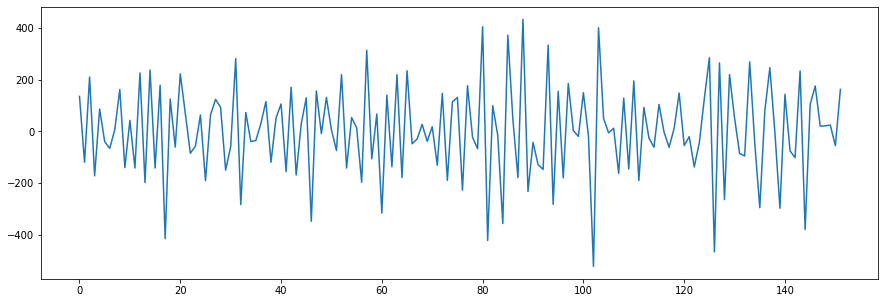

In [13]:
df_del_diff4 = inst4.deltaHedge(step_down_li4,prePay_rate_li4,prepay_date_li4,Delta_Hedge_sim,S1,S2,S3)
plt.figure(figsize=(15,5))
plt.plot(df_del_diff4["Total Delta"])
plt.show()

In [55]:
# case1

val_date1 ="2021-06-09"
barrier1 = 0.5
prePay_rate_li1 = [0.015,0.03,0.045,0.06,0.075,0.09]
step_down_li1 = [0.95,0.9,0.85,0.8,0.75,0.7]
step_down_li_2nd1 = [0.9,0.85,0.8,np.inf,np.inf,np.inf]
prepay_date_li1 = ["2021-12-09", "2022-06-09", "2022-12-09"]


inst1 = Case1n3(sim_num,T,dt,Face_value, val_date)
case1_price = inst1.price_ELS(barrier1, step_down_li_2nd1,step_down_li1,prePay_rate_li1,init_iter_num,S1,S2,S3)
case1_price

9151.692461245051

In [ ]:
step_down_li, prePay_rate_li, step_down_li_2nd, prepay_date_li, barrier, sim_num

In [56]:
df_del_diff1 = inst1.deltaHedge(step_down_li1, prePay_rate_li1, step_down_li_2nd1, prepay_date_li1, barrier1, Delta_Hedge_sim)
plt.figure(figsize=(15,5))
plt.plot(df_del_diff4["Total Delta"])
plt.show()


KeyError: '2021-12-09'

In [59]:
kk=(df_kospi.loc[val_date1:] / df_kospi.loc[val_date1,"kos"] *100)
ss=(df_snp.loc[val_date1:] / df_snp.loc[val_date1,"snp"]* 100)
ee=(df_euro.loc[val_date1:] / df_euro.loc[val_date1,"eur"]* 100)
underlying_agg=pd.concat([kk,ss,ee],axis=1).ffill()
underlying_agg

,kos,snp,eur
0,,,
2021-06-09,100.000000,100.000000,100.000000
2021-06-10,100.277933,100.465215,99.980961
2021-06-11,101.079036,100.660971,100.728609
2021-06-14,101.181801,100.843692,100.874330
2021-06-15,101.394339,100.640827,101.139168
...,...,...,...
2023-01-02,67.682642,90.993115,94.123290
2023-01-03,67.633595,90.629096,94.762806
2023-01-04,69.128363,91.312344,97.000622


In [58]:
kk=(df_kospi.loc[val_date1:] / df_kospi.loc[val_date1,"kos"] *100)
ss=(df_snp.loc[val_date1:] / df_snp.loc[val_date1,"snp"]* 100)
ee=(df_euro.loc[val_date1:] / df_euro.loc[val_date1,"eur"]* 100)
underlying_agg=pd.concat([kk,ss,ee],axis=1).ffill()

limit_idx = len(underlying_agg)
for i in range(len(prepay_date_li1)):
    a = (np.sum(underlying_agg.loc[(prepay_date_li1[i]),:] < step_down_li1[i]*100)==0)    # 기준보다 적은 경우가 한건도 없는 경우 조기상환
    if (a == False) & (i < len(prepay_date_li1)):                                        # 1차기준은 만족하지 못했지만 x-2차기준을 만족한 경우 선별
        b = (np.sum(underlying_agg.loc[:(prepay_date_li1[i]),:] < step_down_li_2nd1[i]*100).sum() == 0)

    if (a == True) | (b ==True):
        limit_idx = np.where(underlying_agg.index == prepay_date_li1[i])[0][0]
        break

In [698]:
#case3
sim_num = 10000; T=3; dt=1/52; Face_value=10000
val_date ="2022-06-09"

barrier3 = 0.5
prePay_rate_li3 = [0.03,0.06,0.09,0.12,0.15,0.18]
step_down_li3 = [0.95,0.9,0.85,0.8,0.75,0.7]
step_down_li_2nd3 = [0.9,0.85,0.8,np.inf,np.inf,np.inf]
prepay_date_li3 = ["2022-12-09"]

inst3 = Case1n3(sim_num,T,dt,Face_value, val_date)
case3_price = inst3.price_ELS(barrier3, step_down_li_2nd3,step_down_li3,prePay_rate_li3,init_iter_num,S1,S2,S3)
case3_price

9525.017388487247

100%|██████████| 152/152 [01:41<00:00,  1.50it/s]


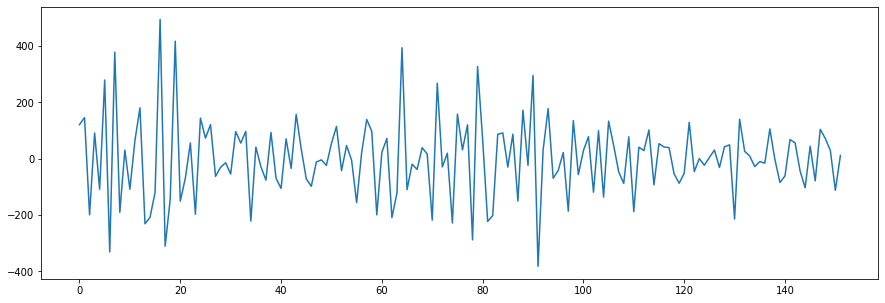

In [232]:
df_del_diff3 = inst3.deltaHedge(step_down_li3,prePay_rate_li3,prepay_date_li3, step_down_li_2nd3, barrier3,Delta_Hedge_sim,S1,S2,S3)
plt.figure(figsize=(15,5))
plt.plot(df_del_diff4["Total Delta"])
plt.show()
